In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
np.random.seed(20)

In [233]:
X, Y = make_classification(n_samples=1000, n_classes=2, n_informative=2, n_features=4)
X = X.reshape(X.shape[1], X.shape[0])
Y = Y.reshape(1, -1)
print(X.shape, Y.shape)

(4, 1000) (1, 1000)


In [234]:
X = (X - np.mean(X, axis=1, keepdims=True)) / np.std(X, axis=1, keepdims=True)

In [235]:
layer_dims = [4, 3, 2, 1]

In [236]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters 

In [237]:
parameters = initialize_parameters_deep(layer_dims)
for item in parameters.items():
    print(f'{item[0]} -- {item[1].shape}')

W1 -- (3, 4)
b1 -- (3, 1)
W2 -- (2, 3)
b2 -- (2, 1)
W3 -- (1, 2)
b3 -- (1, 1)


In [238]:
def linear_forward(A_prev, W, b):

    Z = np.dot(W, A_prev) + b

    cache = (A_prev, W, b)

    return Z, cache

In [239]:
Z, cache = linear_forward(X, parameters['W1'], parameters['b1'])
print(Z.shape)
print(cache)

(3, 1000)
(array([[-1.21583985,  1.18096449, -0.42323228, ...,  1.51738674,
         0.29790921, -0.54129285],
       [ 2.16750688, -1.97855895,  0.78414393, ..., -1.60416097,
        -1.31944325,  0.25547921],
       [-1.06911394,  1.46544705,  0.09211659, ..., -0.25214087,
         0.06607242,  0.06544213],
       [ 0.56168333,  0.5336023 ,  1.11479879, ...,  0.23414023,
        -1.77325064, -0.78463314]]), array([[ 0.00424234,  0.02030557,  0.00410939, -0.0018824 ],
       [-0.01005195, -0.01171323,  0.01247126, -0.01041325],
       [-0.02320599, -0.01172002,  0.00114138,  0.00161437]]), array([[0.],
       [0.],
       [0.]]))


In [240]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))

    return A, Z

In [241]:
def relu(Z):
    A = np.maximum(0.0, Z)

    return A, Z

In [242]:
def tanh(Z):
    A = np.tanh(Z)

    return A, Z

In [243]:
def linear_activation_forward(A_prev, W, b, activation):

    if activation == 'sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == 'tanh':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    
    elif activation == 'relu':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)

    return A, cache 

In [244]:
A, cache = linear_activation_forward(X, parameters['W1'], parameters['b1'], 'relu')
print(A.shape)

(3, 1000)


In [245]:
def L_model_forward(X, parameters):
    
    caches = []
    A = X

    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], 'relu')
        caches.append(cache)


    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], 'sigmoid')
    caches.append(cache)

    return AL, caches

In [266]:
def compute_cost(Y, AL, eps=1e-12):

    m = Y.shape[1]

    cost = -1/m * np.sum((Y*np.log(AL + eps) + (1 - Y)*np.log(1 - AL + eps)))
    return np.squeeze(cost)

In [267]:
AL, caches = L_model_forward(X, parameters)
cost = compute_cost(Y, AL)
print(cost)

0.6931471827307196


In [268]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [286]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0
    return dZ

In [287]:
def tanh_backward(dA, activation_cache):
    Z = activation_cache
    return dA * (1 - np.tanh(Z) ** 2)

In [288]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    A = 1 / (1 + np.exp(-Z))
    return dA * A * (1 - A)

In [289]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == 'tanh':
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == 'sigmoid':
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    elif activation == 'relu':
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db

In [290]:
def L_model_backward(AL, Y, caches, eps=1e-12):
    dAL = - (np.divide(Y, AL + eps) - np.divide((1 - Y), (1 - AL + eps)))
    Y = Y.reshape(AL.shape)
    L = len(caches)

    grads = {}
    current_cache = caches[L - 1]
    dA_prev, dW, db = linear_activation_backward(dAL, current_cache, 'sigmoid')
    grads['dA' + str(L - 1)] = dA_prev
    grads['dW' + str(L)] = dW
    grads['db' + str(L)] = db

    for l in reversed(range(L - 1)):
        current_cache = caches[l]
        dA_prev, dW, db = linear_activation_backward(dA_prev, current_cache, 'relu')
        grads['dA' + str(l)] = dA_prev
        grads['dW' + str(l + 1)] = dW
        grads['db' + str(l + 1)] = db


    return grads



In [291]:
def update_parameters(parameters, grads, learning_rate=0.001):

    L = len(parameters) // 2

    for l in range(L):
        parameters['W' + str(l + 1)] -= learning_rate * grads['dW' + str(l + 1)]
        parameters['b' + str(l + 1)] -= learning_rate * grads['db' + str(l + 1)]


    return parameters

    

In [292]:
parameters = initialize_parameters_deep(layer_dims)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))
grads = L_model_backward(AL, Y, caches)
parameters = update_parameters(parameters, grads)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))
grads = L_model_backward(AL, Y, caches)
parameters = update_parameters(parameters, grads)
AL, caches = L_model_forward(X, parameters)
print(compute_cost(Y, AL))

0.6931471854506948
0.6931471764403996
0.6931471674273767


In [293]:
def L_layer_model(X, Y, learning_rate=0.01, num_iterations=1000, print_cost=False):
    parameters = initialize_parameters_deep(layer_dims)
    costs = []
    epsilon = 1e-15
    for i in range(num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print(f"Cost after iteration {i}: {np.squeeze(cost):.4f}")
        if i % 100 == 0:
            costs.append(cost)

    return parameters, costs

In [294]:
params, costs = L_layer_model(X, Y, print_cost=True)

Cost after iteration 0: 13.8155
Cost after iteration 100: 13.8154
Cost after iteration 200: 13.8153
Cost after iteration 300: 13.8152
Cost after iteration 400: 13.8152
Cost after iteration 500: 13.8152
Cost after iteration 600: 13.8151
Cost after iteration 700: 13.8151
Cost after iteration 800: 13.8151
Cost after iteration 900: 13.8151
Cost after iteration 999: 13.8151


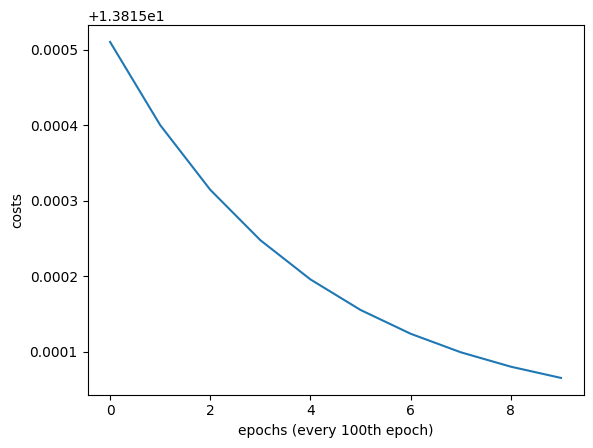

In [295]:
plt.plot(range(len(costs)), costs)
plt.xlabel('epochs (every 100th epoch)')
plt.ylabel('costs')
plt.show()